In [1]:
#!pip install lightgbm

In [2]:
from IPython.display import display
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn import feature_extraction
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm, tqdm_notebook
from itertools import product
import warnings
%matplotlib inline 
tqdm.monitor_interval = 0
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [4]:
sales = pd.read_csv('https://raw.githubusercontent.com/ChristianUrrego/DataScienceCompetition/master/Data/sales_train.csv')
shops = pd.read_csv('https://raw.githubusercontent.com/ChristianUrrego/DataScienceCompetition/master/Data/shops.csv')
items = pd.read_csv('https://raw.githubusercontent.com/ChristianUrrego/DataScienceCompetition/master/Data/items.csv')
item_cats = pd.read_csv('https://raw.githubusercontent.com/ChristianUrrego/DataScienceCompetition/master/Data/item_categories.csv')
test = pd.read_csv('https://raw.githubusercontent.com/ChristianUrrego/DataScienceCompetition/master/Data/test.csv')

In [5]:
print(sales.shape)
sales.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


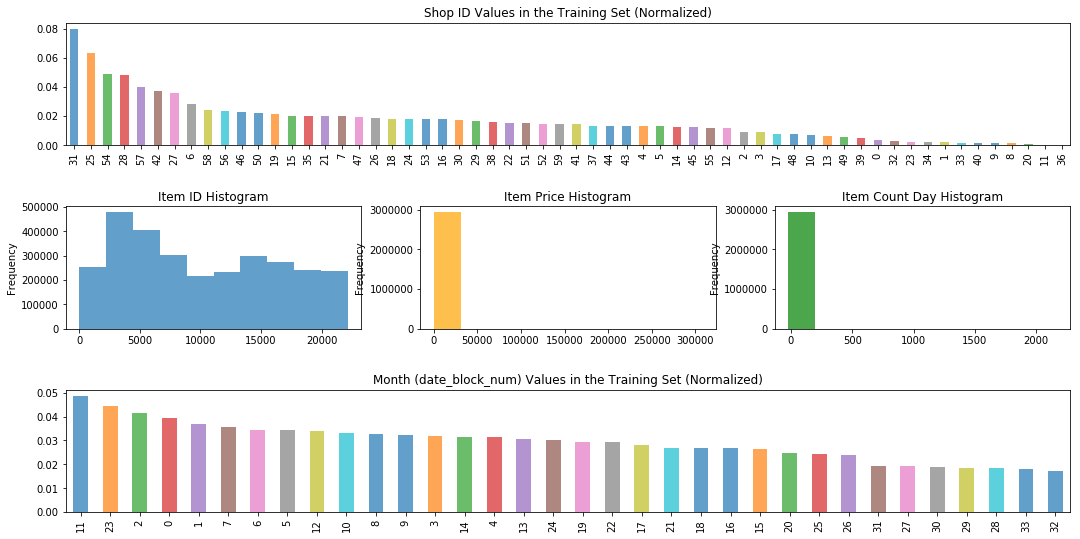

In [7]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
sales['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
sales['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram')

plt.subplot2grid((3,3), (1,1))
sales['item_price'].plot(kind='hist', alpha=0.7, color='orange')
plt.title('Item Price Histogram')

plt.subplot2grid((3,3), (1,2))
sales['item_cnt_day'].plot(kind='hist', alpha=0.7, color='green')
plt.title('Item Count Day Histogram')

plt.subplot2grid((3,3), (2,0), colspan = 3)
sales['date_block_num'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Month (date_block_num) Values in the Training Set (Normalized)')

plt.show()

In [8]:
sales['item_id'].value_counts(ascending=False)[:5]

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
Name: item_id, dtype: int64

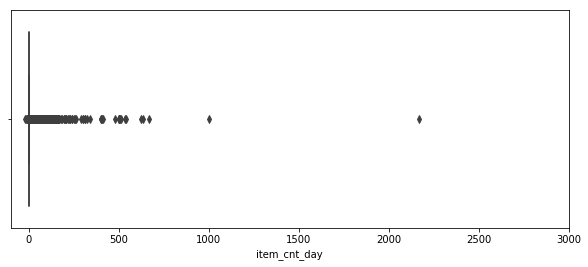

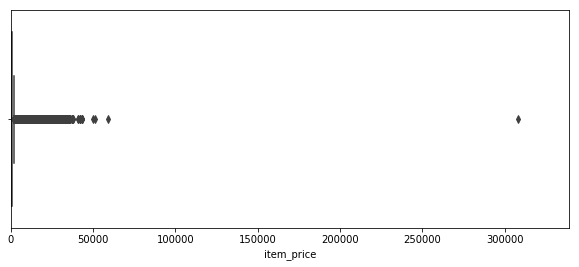

In [9]:
import seaborn as sns

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price)

In [10]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<1001]

In [11]:
shops.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
shop_name,"!Якутск Орджоникидзе, 56 фран","!Якутск ТЦ ""Центральный"" фран","Адыгея ТЦ ""Мега""","Балашиха ТРК ""Октябрь-Киномир""","Волжский ТЦ ""Волга Молл""","Вологда ТРЦ ""Мармелад""","Воронеж (Плехановская, 13)","Воронеж ТРЦ ""Максимир""","Воронеж ТРЦ Сити-Парк ""Град""",Выездная Торговля,Жуковский ул. Чкалова 39м?,Жуковский ул. Чкалова 39м²,Интернет-магазин ЧС,"Казань ТЦ ""Бехетле""","Казань ТЦ ""ПаркХаус"" II","Калуга ТРЦ ""XXI век""","Коломна ТЦ ""Рио""","Красноярск ТЦ ""Взлетка Плаза""","Красноярск ТЦ ""Июнь""","Курск ТЦ ""Пушкинский""","Москва ""Распродажа""","Москва МТРЦ ""Афи Молл""",Москва Магазин С21,"Москва ТК ""Буденовский"" (пав.А2)","Москва ТК ""Буденовский"" (пав.К7)",...,"Н.Новгород ТРЦ ""Фантастика""","Новосибирск ТРЦ ""Галерея Новосибирск""","Новосибирск ТЦ ""Мега""","Омск ТЦ ""Мега""","РостовНаДону ТРК ""Мегацентр Горизонт""","РостовНаДону ТРК ""Мегацентр Горизонт"" Островной","РостовНаДону ТЦ ""Мега""","СПб ТК ""Невский Центр""","СПб ТК ""Сенная""","Самара ТЦ ""Мелодия""","Самара ТЦ ""ПаркХаус""","Сергиев Посад ТЦ ""7Я""","Сургут ТРЦ ""Сити Молл""","Томск ТРЦ ""Изумрудный Город""","Тюмень ТРЦ ""Кристалл""","Тюмень ТЦ ""Гудвин""","Тюмень ТЦ ""Зеленый Берег""","Уфа ТК ""Центральный""","Уфа ТЦ ""Семья"" 2","Химки ТЦ ""Мега""",Цифровой склад 1С-Онлайн,"Чехов ТРЦ ""Карнавал""","Якутск Орджоникидзе, 56","Якутск ТЦ ""Центральный""","Ярославль ТЦ ""Альтаир"""
shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59


In [12]:
sales.loc[sales.shop_id == 0, "shop_id"] = 57
test.loc[test.shop_id == 0 , "shop_id"] = 57
sales.loc[sales.shop_id == 1, "shop_id"] = 58
test.loc[test.shop_id == 1 , "shop_id"] = 58
sales.loc[sales.shop_id == 11, "shop_id"] = 10
test.loc[test.shop_id == 11, "shop_id"] = 10
sales.loc[sales.shop_id == 40, "shop_id"] = 39
test.loc[test.shop_id == 40, "shop_id"] = 39

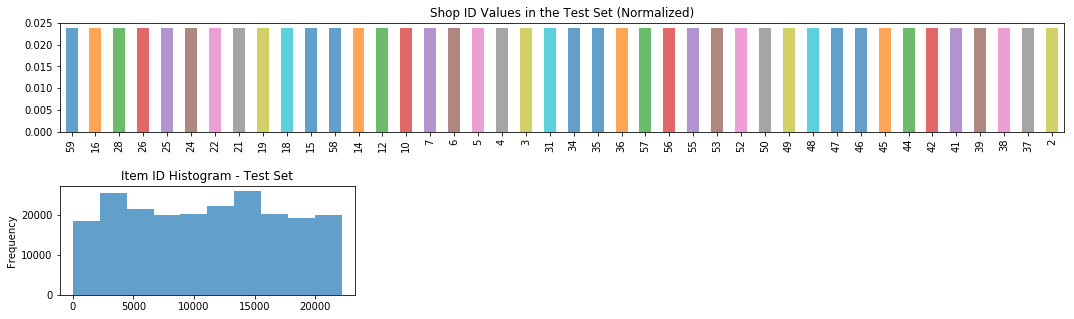

In [13]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
test['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Test Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
test['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram - Test Set')

plt.show()

In [14]:
test_block = sales['date_block_num'].iloc[-1] + 1
test['date_block_num'] = test_block
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [15]:
target_range = [0, 20]

In [16]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid = pd.concat([grid, test])

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [17]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(['ID'] + index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
# item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

# all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [18]:
all_data.head(5)

,ID,date_block_num,item_id,shop_id,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
4488710,0.0,12,10297,54,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488711,0.0,12,10296,54,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488712,0.0,12,10298,54,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488713,0.0,12,10300,54,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488714,0.0,12,10284,54,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0


In [19]:
#Text Features
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
items['item_name_len'] = items['item_name'].map(len) #Lenth of Item Description
items['item_name_wc'] = items['item_name'].map(lambda x: len(str(x).split(' '))) #Item Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(items['item_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    items['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
items.drop(columns='item_name', inplace=True)
items.head()

,item_id,item_category_id,item_name_len,item_name_wc,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,0,40,41,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,76,68,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.637898,0.0,0.0,0.0,0.0,0.442678,0.0,0.0,0.0,0.403761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483839
2,2,40,45,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,3,40,47,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,4,40,43,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [20]:
#Text Features
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
item_cats['item_category_name_len'] = item_cats['item_category_name'].map(len)  #Lenth of Item Category Description
item_cats['item_category_name_wc'] = item_cats['item_category_name'].map(lambda x: len(str(x).split(' '))) #Item Category Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(item_cats['item_category_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    item_cats['item_category_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
item_cats.drop(columns='item_category_name', inplace=True)
item_cats.head()

,item_category_id,item_category_name_len,item_category_name_wc,item_category_name_tfidf_0,item_category_name_tfidf_1,item_category_name_tfidf_2,item_category_name_tfidf_3,item_category_name_tfidf_4,item_category_name_tfidf_5,item_category_name_tfidf_6,item_category_name_tfidf_7,item_category_name_tfidf_8,item_category_name_tfidf_9,item_category_name_tfidf_10,item_category_name_tfidf_11,item_category_name_tfidf_12,item_category_name_tfidf_13,item_category_name_tfidf_14,item_category_name_tfidf_15,item_category_name_tfidf_16,item_category_name_tfidf_17,item_category_name_tfidf_18,item_category_name_tfidf_19,item_category_name_tfidf_20,item_category_name_tfidf_21,item_category_name_tfidf_22,item_category_name_tfidf_23,item_category_name_tfidf_24
0,0,23,3,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,16,3,0.0,0.0,0.0,0.0,0.780837,0.000000,0.000000,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,16,3,0.0,0.0,0.0,0.0,0.000000,0.780837,0.000000,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,16,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.780837,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,16,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
#Text Features
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
shops['shop_name_len'] = shops['shop_name'].map(len)  #Lenth of Shop Name
shops['shop_name_wc'] = shops['shop_name'].map(lambda x: len(str(x).split(' '))) #Shop Name Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    shops['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
shops.drop(columns='shop_name', inplace=True)
shops.head()

,shop_id,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,0,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000
1,1,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322815,0.0,0.689588,0.648274
2,2,16,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498580,0.0,0.000000,0.000000
3,3,30,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000
4,4,24,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.905675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.0,0.000000,0.000000


In [22]:
#Items features
all_data = pd.merge(all_data, items, how='left', on='item_id')
#Item Category features
all_data = pd.merge(all_data, item_cats, how='left', on='item_category_id')
#Shops features
all_data = pd.merge(all_data, shops, how='left', on='shop_id')
all_data = downcast_dtypes(all_data)
all_data.head()

,ID,date_block_num,item_id,shop_id,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,...,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,0.0,12,10297,54,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
1,0.0,12,10296,54,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
2,0.0,12,10298,54,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
3,0.0,12,10300,54,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
4,0.0,12,10284,54,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0


In [23]:
dates = all_data['date_block_num']

print('Test `date_block_num` is %d' % test_block)

Test `date_block_num` is 34


In [24]:
dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

X_train = all_data.loc[dates <  test_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  test_block, 'target'].values
y_test =  all_data.loc[dates == test_block, 'target'].values

In [25]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values).clip(*target_range)

In [26]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test).clip(*target_range)

In [27]:
X_test_level2 = np.c_[pred_lr, pred_lgb]

In [28]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(dates_train_level2)]

In [29]:
# And here we create 2nd level feeature matrix, init it with zeros first# And he 
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
pbar = tqdm_notebook(dates_train_level2.unique())
for cur_block_num in pbar:
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           We can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    pbar.set_description('{}: Split'.format(cur_block_num))
    _X_train = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    _X_test =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    _y_train = all_data.loc[dates <  cur_block_num, 'target'].values
    _y_test =  all_data.loc[dates == cur_block_num, 'target'].values
    
    pbar.set_description('{}: LR'.format(cur_block_num))
    lr.fit(_X_train.values, _y_train)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = lr.predict(_X_test.values).clip(*target_range)
    
    pbar.set_description('{}: LGB'.format(cur_block_num))
    model = lgb.train(lgb_params, lgb.Dataset(_X_train, label=_y_train), 100)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = model.predict(_X_test).clip(*target_range)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


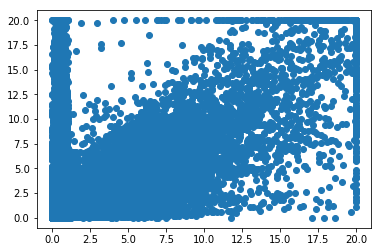

In [30]:
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

In [31]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = np.array([r2_score(y_train_level2, np.dot(X_train_level2, [alpha, 1 - alpha])) for alpha in alphas_to_try])
best_alpha = alphas_to_try[r2_scores.argmax()]
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.000000; Corresponding r2 score on train: 0.101347


In [32]:
test_preds = best_alpha * pred_lr + (1 - best_alpha) * pred_lgb
test['item_cnt_month'] = test_preds
test[['ID', 'item_cnt_month']].to_csv('submission_averaging.csv', index=False)

In [33]:
lr.fit(X_train_level2, y_train_level2)

LinearRegression()

In [34]:
train_preds = lr.predict(X_train_level2).clip(*target_range)
r2_train_stacking = r2_score(y_train_level2, train_preds)

test_preds = lr.predict(np.vstack((pred_lr, pred_lgb)).T).clip(*target_range)
test['item_cnt_month'] = test_preds
test[['ID', 'item_cnt_month']].to_csv('submission_stacking.csv', index=False)

print('Train R-squared for stacking is %f' % r2_train_stacking)

Train R-squared for stacking is 0.094282
